In [2]:
  import tensorflow as tf

In [1]:
!pip install scipy==1.2.1

     |████████████████████████████████| 24.8MB 150kB/s 
ERROR: umap-learn 0.4.6 has requirement scipy>=1.3.1, but you'll have scipy 1.2.1 which is incompatible.
ERROR: tensorflow 2.3.0 has requirement scipy==1.4.1, but you'll have scipy 1.2.1 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: scipy 1.4.1
    Uninstalling scipy-1.4.1:
      Successfully uninstalled scipy-1.4.1


In [3]:
!pip install -q imageio

In [4]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time

from IPython import display

In [5]:
(trn_images, trn_labels) , (_, _)  = tf.keras.datasets.mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


In [12]:

b = trn_images.reshape(-1,20,20)# to reshape the whole image dataset -1 is used in first argument in the reshape function


In [13]:
b.shape

(117600, 20, 20)

In [6]:
(train_images, train_labels), (_, _) = tf.keras.datasets.cifar10.load_data()

170500096/170498071 [==============================] - 2s 0us/step


In [7]:
train_images.shape

(50000, 32, 32, 3)

In [8]:
from scipy.misc import imresize
from numpy import array

In [9]:
#convert training images to low resolution to feed to the generator network
def lr_images(images_real , downscale):
    
    images = []
    for img in  range(len(images_real)):
        images.append(imresize(images_real[img], [images_real[img].shape[0]//downscale,images_real[img].shape[1]//downscale], interp='bicubic', mode=None))
    images_lr = array(images)
    return images_lr

In [10]:
x_train_lr = lr_images(train_images, 4)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.
  


In [11]:
print(x_train_lr.shape)

(50000, 8, 8, 3)


In [12]:
x_train_lr  = x_train_lr.reshape(-1,32,32,3) 
train_images = train_images.reshape(-1,32,32,3)

In [13]:
#train_images = train_images.reshape(train_images.shape[0], 32, 32, 3).astype('float32')
train_images = (train_images - 127.5) / 127.5 # Normalize the discriminator images to [-1, 1]
x_train_lr  = (x_train_lr - 127.5) / 127.5 # Normalize the generator images to [-1, 1]
print(train_images.shape)
print(x_train_lr.shape)

(50000, 32, 32, 3)
(3125, 32, 32, 3)


In [14]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256

In [ ]:
def make_generator_model_must():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256) # Note: None is the batch size

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model

In [ ]:
make_generator_model_must().summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 12544)             1254400   
_________________________________________________________________
batch_normalization_6 (Batch (None, 12544)             50176     
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 12544)             0         
_________________________________________________________________
reshape_4 (Reshape)          (None, 7, 7, 256)         0         
_________________________________________________________________
conv2d_transpose_6 (Conv2DTr (None, 7, 7, 128)         819200    
_________________________________________________________________
batch_normalization_7 (Batch (None, 7, 7, 128)         512       
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 7, 7, 128)        

In [15]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(100, use_bias=False, input_shape=(32,32,3)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((32,32,100)))
    assert model.output_shape == (None, 32,32,100) # Note: None is the batch size

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 32, 32, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    #assert model.output_shape == (None, 64, 64, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(3, (5, 5), strides=(1, 1), padding='same', use_bias=False, activation='tanh'))
    model.add(layers.Reshape((32,32,3)))
    assert model.output_shape == (None, 32, 32, 3)
    print(model.output_shape)
    print(model.summary)
    return model

In [16]:
make_generator_model().summary()

(None, 32, 32, 3)
<bound method Model.summary of <tensorflow.python.keras.engine.sequential.Sequential object at 0x7f5909f30f28>>
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32, 32, 100)       300       
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 100)       400       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 32, 32, 100)       0         
_________________________________________________________________
reshape (Reshape)            (None, 32, 32, 100)       0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 32, 32, 128)       320000    
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 128)       512

In [30]:
generator = make_generator_model()

(None, 32, 32, 3)
<bound method Model.summary of <tensorflow.python.keras.engine.sequential.Sequential object at 0x7f58fa4f9c88>>


In [25]:
from google.colab import files
from io import BytesIO
from PIL import Image

uploaded = files.upload()


Saving horse.jpeg to horse.jpeg


In [28]:
import matplotlib.pyplot as plt
import cv2
im = cv2.imread('horse.jpg')
resize_im = cv2.resize(im,(32,32))
print(resize_im.shape)
plt.imshow(im)
plt.show()

error: ignored

In [ ]:
X = []
X.append(resize_im)
X = np.array(X).reshape(-1,32,32,3)
print(X.shape)

(1, 32, 32, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(None, 32, 32, 3)
<bound method Network.summary of <tensorflow.python.keras.engine.sequential.Sequential object at 0x7fdc944d3198>>
(1, 32, 32, 3)


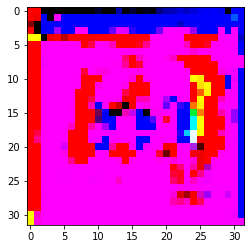

In [ ]:
generator = make_generator_model()
generated_image = generator(X, training=False)
#X_2 = np.array(generated_image).reshape(280,280,3)
#print(generated_image)
print(generated_image.shape)
plt.imshow(generated_image[0, :, :, :])


In [17]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[32,32,3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))
    
    return model

In [18]:
make_discriminator_model().summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 16, 16, 64)        4864      
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 16, 16, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 128)         204928    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 8, 8, 128)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 8, 8, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 8192)             

In [29]:
discriminator = make_discriminator_model()

In [ ]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[-0.04874514]], shape=(1, 1), dtype=float32)


In [19]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [20]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [21]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [22]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [31]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 discriminator=discriminator,
                                 generator=generator
                                 )

In [ ]:
EPOCHS = 10
noise_dim = 100
num_examples_to_generate = 32

# We will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([1,32,32,3])


In [32]:
@tf.function
def train_step(images):
    #noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(x_train_lr, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [33]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    # Produce images for the GIF as we go
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             X)

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           X)

In [34]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(30,30))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, :] * 127.5 + 127.5)
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

In [35]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
print(train_dataset)

<BatchDataset shapes: (None, 32, 32, 3), types: tf.float64>


In [37]:
EPOCHS = 10

In [ ]:
train(train_dataset, EPOCHS)